# Text Generation, LSTM with Attention.
We know that attention can be used to "lookup" or "query" a set of values. Lets look at how we can use it to query the outputs of an LSTM at previous timesteps. By directly querying the outputs we can pull the information directly, by-passing the "memory cell" bottle-neck. 

[<img src="../data/LSTM_Attention.jpg">](LSTM_attention)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import io
import re

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from torch.distributions import Categorical

from torchtext.datasets import WikiText2, EnWik9, AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
from torch.hub import load_state_dict_from_url
from torchtext.data.functional import sentencepiece_tokenizer, load_sp_model

from tqdm.notebook import trange, tqdm

In [2]:
# Define the hyperparameters
learning_rate = 1e-4

nepochs = 20

batch_size = 32

max_len = 128
data_set_root = "../../datasets"

# We'll be using the AG News Dataset
# Which contains a short news article and a single label to classify the "type" of article
# Note that for torchtext these datasets are NOT Pytorch dataset classes "AG_NEWS" is a function that
# returns a Pytorch DataPipe!

# Pytorch DataPipes vvv
# https://pytorch.org/data/main/torchdata.datapipes.iter.html

# vvv Good Blog on the difference between DataSet and DataPipe
# https://medium.com/deelvin-machine-learning/comparison-of-pytorch-dataset-and-torchdata-datapipes-486e03068c58
# Depending on the dataset sometimes the dataset doesn't download and gives an error
# and you'll have to download and extract manually 
# "The datasets supported by torchtext are datapipes from the torchdata project, which is still in Beta status"

# Un-comment to triger the DataPipe to download the data vvv
# dataset_train = AG_NEWS(root=data_set_root, split="train")
# data = next(iter(dataset_train))

# Side-Note I've noticed that the WikiText dataset is no longer able to be downloaded :(

In [3]:
class AGNews(Dataset):
    def __init__(self, num_datapoints, test_train="train"):
        self.df = pd.read_csv(os.path.join(data_set_root, "datasets/AG_NEWS/" + test_train + ".csv"),
                              names=["Class", "Title", "Content"])
        
        self.df.fillna('', inplace=True)
        self.df['Article'] = self.df['Title'] + " : " + self.df['Content']
        self.df.drop(['Title', 'Content'], axis=1, inplace=True)
        self.df['Article'] = self.df['Article'].str.replace(r'\\n|\\|\\r|\\r\\n|\n|"', ' ', regex=True)

    def __getitem__(self, index):
        text = self.df.loc[index]["Article"].lower()

        return text

    def __len__(self):
        return len(self.df)

In [4]:
dataset_train = AGNews(num_datapoints=data_set_root, test_train="train")
dataset_test = AGNews(num_datapoints=data_set_root, test_train="test")

In [5]:
# Un-Comment to train sentence-piece model for tokenizer and vocab!

# from torchtext.data.functional import generate_sp_model

# with open(os.path.join(data_set_root, "datasets/AG_NEWS/train.csv")) as f:
#     with open(os.path.join(data_set_root, "datasets/AG_NEWS/data.txt"), "w") as f2:
#         for i, line in enumerate(f):
#             text_only = "".join(line.split(",")[1:])
#             filtered = re.sub(r'\\|\\n|;', ' ', text_only.replace('"', ' ').replace('\n', ' ')) # remove newline characters
#             f2.write(filtered.lower() + "\n")

# generate_sp_model(os.path.join(data_set_root, "datasets/AG_NEWS/data.txt"), 
#                   vocab_size=20000, model_prefix='spm_ag_news')

In [6]:
# Example of using the tokenizer!
sp_model = load_sp_model("spm_ag_news.model")

# Returns a generator object
tokenizer = sentencepiece_tokenizer(sp_model)

# Iterate over tokens
for token in tokenizer(["i am creating"]):
    print(token)

['▁i', '▁am', '▁creat', 'ing']


In [7]:
def yield_tokens(file_path):
    with io.open(file_path, encoding = 'utf-8') as f:
        for line in f:
            yield [line.split("\t")[0]]
            
vocab = build_vocab_from_iterator(yield_tokens("spm_ag_news.vocab"), 
                                  specials=['<pad>', '<sos>', '<eos>', '<unk>'],
                                  special_first=True)
vocab.set_default_index(vocab['<unk>'])

In [8]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p=prob
        # to create a mask where 1 means we will replace that token
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # only replace if the token is not a special token
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

In [9]:
train_tranform = T.Sequential(
    # Tokeniz with pre-existing Tokenizer
    T.SentencePieceTokenizer("spm_ag_news.model"),
    ## converts the sentences to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
    # 1 as seen in previous section
    T.AddToken(1, begin=True),
    # Crop the sentance if it is longer than the max length
    T.Truncate(max_seq_len=max_len),
    ## Add <eos> at beginning of each sentence. 2 because the index for <eos> in vocabulary is
    # 2 as seen in previous section
    T.AddToken(2, begin=False),
    # Convert the list of lists to a tensor, this will also
    # Pad a sentence with the <pad> token if it is shorter than the max length
    # This ensures all sentences are the same length!
    T.ToTensor(padding_value=0),
)

gen_tranform = T.Sequential(
    # Tokeniz with pre-existing Tokenizer
    T.SentencePieceTokenizer("spm_ag_news.model"),
    ## converts the sentences to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
    # 1 as seen in previous section
    T.AddToken(1, begin=True),
    # Convert the list of lists to a tensor, this will also
    # Pad a sentence with the <pad> token if it is shorter than the max length
    # This ensures all sentences are the same length!
    T.ToTensor(padding_value=0)
)


In [10]:
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=8)

In [11]:
text = next(iter(data_loader_train))
index = 0
input_tokens = train_tranform(text)
print("SENTENCE")
print(text[index])
print()
print("TOKENS")
print(vocab.lookup_tokens(input_tokens[index].numpy()))

SENTENCE
minutemen on the clock : there's trouble in the atlantic 10. the league that received four ncaa bids and had two teams advance to the elite eight last season most likely will not repeat that success. nine of the league's top 10 scorers have either graduated, left early for the nba, or just left.

TOKENS
['<sos>', '▁minute', 'men', '▁on', '▁the', '▁clock', '▁:', '▁there', "'", 's', '▁trouble', '▁in', '▁the', '▁atlantic', '▁10', '.', '▁the', '▁league', '▁that', '▁received', '▁four', '▁ncaa', '▁bids', '▁and', '▁had', '▁two', '▁teams', '▁advance', '▁to', '▁the', '▁elite', '▁eight', '▁last', '▁season', '▁most', '▁likely', '▁will', '▁not', '▁repeat', '▁that', '▁success', '.', '▁nine', '▁of', '▁the', '▁league', "'", 's', '▁top', '▁10', '▁scorer', 's', '▁have', '▁either', '▁graduate', 'd', '<unk>', '▁left', '▁early', '▁for', '▁the', '▁nba', '<unk>', '▁or', '▁just', '▁left', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',

In [12]:
print("TOKENS BACK TO SENTENCE")

pred_text = "".join(vocab.lookup_tokens(input_tokens[index].numpy()))
pred_text.replace("▁", " ")

TOKENS BACK TO SENTENCE


"<sos> minutemen on the clock : there's trouble in the atlantic 10. the league that received four ncaa bids and had two teams advance to the elite eight last season most likely will not repeat that success. nine of the league's top 10 scorers have either graduated<unk> left early for the nba<unk> or just left.<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>"

In [13]:
class LSTM(nn.Module):
    def __init__(self, num_emb, num_layers=1, emb_size=128, hidden_size=128):
        super(LSTM, self).__init__()
        
        self.embedding = nn.Embedding(num_emb, emb_size)

        self.mlp_emb = nn.Sequential(nn.Linear(emb_size, emb_size),
                                     nn.LayerNorm(emb_size),
                                     nn.ELU(),
                                     nn.Linear(emb_size, emb_size))
        
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=0.25)
        
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, 
                                               num_heads=4,
                                               batch_first=True)

        self.mlp_out = nn.Sequential(nn.Linear(hidden_size, hidden_size//2),
                                     nn.LayerNorm(hidden_size//2),
                                     nn.ELU(),
                                     nn.Dropout(0.5),
                                     nn.Linear(hidden_size//2, num_emb))
        
    def forward(self, input_token, hidden_seq, hidden_in, mem_in):
        input_embs = self.embedding(input_token)
        input_embs = self.mlp_emb(input_embs)
                
        # Pass Through LSTM
        output, (hidden_out, mem_out) = self.lstm(input_embs, (hidden_in, mem_in))
        # Log the output of the final LSTM layer
        hidden_seq += [output]
        hidden_cat = torch.cat(hidden_seq, 1)
        
        # Cast attention over the outputs of the LSTM from all previous steps
        # Use a single query from the current timestep
        # Keys and Values created from the outputs of LSTM from all timesteps
        attn_output, attn_output_weights = self.attention(output, hidden_cat, hidden_cat)  # Q, K, V
        attn_output = attn_output + output
                
        return self.mlp_out(attn_output), hidden_seq, hidden_out, mem_out

In [14]:
device = torch.device(1 if torch.cuda.is_available() else 'cpu')

In [15]:
emb_size = 256
hidden_size = 256

num_layers = 2

# Create model
lstm_generator = LSTM(num_emb=len(vocab), num_layers=num_layers, 
                      emb_size=emb_size, hidden_size=hidden_size).to(device)

# Initialize the optimizer with above parameters
optimizer = optim.Adam(lstm_generator.parameters(), lr=learning_rate, weight_decay=1e-4)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Custom transform that will randomly replace a token with <pad>
td = TokenDrop(prob=0.1)

In [16]:
# cp = torch.load("gen_model.pt")
# lstm_generator.load_state_dict(cp["model"])

In [17]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in lstm_generator.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 9182243 (Approximately 9 Million) Parameters!


In [18]:
training_loss_logger = []
entropy_logger = []

In [ ]:
for epoch in trange(0, nepochs, leave=False, desc="Epoch"):    
    lstm_generator.train()
    steps = 0
    for text in tqdm(data_loader_train, desc="Training", leave=False):
        text_tokens = train_tranform(list(text)).to(device)
        bs = text_tokens.shape[0]
        
        # Randomly drop input tokens
        input_text = td(text_tokens[:, 0:-1])
        output_text = text_tokens[:, 1:]
        
        # Initialise the memory buffers
        hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        memory = torch.zeros(num_layers, bs, hidden_size, device=device)
        
        # Use a list to log the output of the LSTM at each timestep
        hidden_seq = []
        
        # We are going to manually loop the LSTM so we can log the output for the
        # attention mechanism
        loss = 0
        for i in range(input_text.shape[1]):
            input_token = input_text[:, i].unsqueeze(1)
            output_token = output_text[:, i].unsqueeze(1)

            pred, hidden_seq, hidden, memory = lstm_generator(input_token, hidden_seq, hidden, memory)

            loss += loss_fn(pred.transpose(1, 2), output_token)
        
        loss /= (i + 1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss_logger.append(loss.item())
        with torch.no_grad():
            dist = Categorical(logits=pred)
            entropy_logger.append(dist.entropy().mean().item())
            

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

In [20]:
input_token.shape

torch.Size([32, 1])

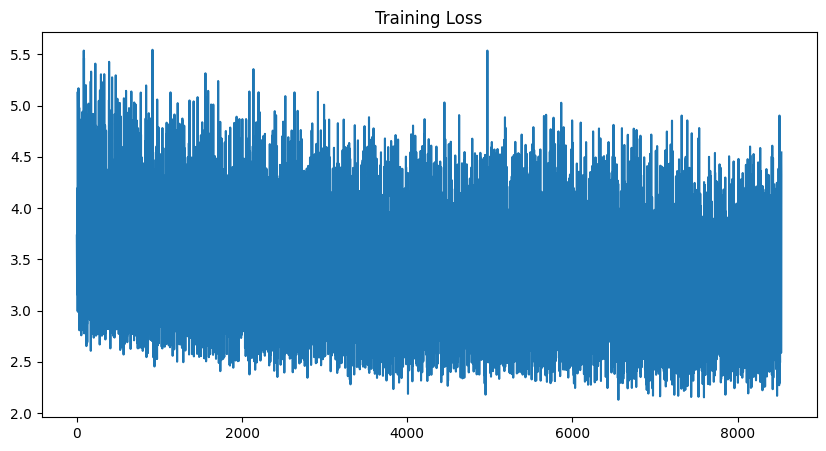

In [21]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger[1000:])
_ = plt.title("Training Loss")

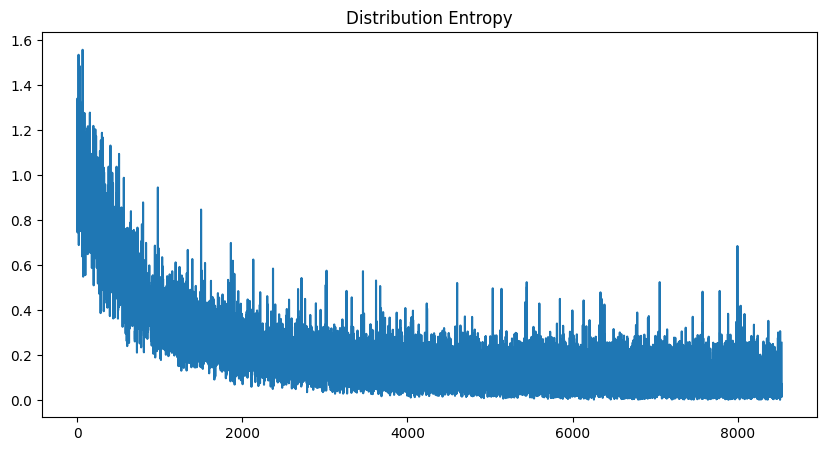

In [22]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(entropy_logger[1000:])
_ = plt.title("Distribution Entropy")

## Generate some text!
Lets use the fact that all of the articles have the title and content seperated by a : to get our model to generate some content based on a title

In [23]:
# Get some test examples
text = next(iter(data_loader_test))

In [28]:
index = 0
temp = 0.8

# We can either use an example from the test set or create our own article title!
# init_prompt = ["the next big thing from google :"]
init_prompt = [text[index].split(":")[0] + ":"]


input_tokens = gen_tranform(init_prompt).to(device)
print("INITIAL PROMPT:")
print(init_prompt[0])

print("\nPROMPT TOKENS:")
print(input_tokens)
print(vocab.lookup_tokens(input_tokens[0].cpu().numpy()))

INITIAL PROMPT:
firefox turns up the browser war heat :

PROMPT TOKENS:
tensor([[    1,  9677, 18871, 19077, 18412,  6307, 19464, 10730,  4553]],
       device='cuda:1')
['<sos>', '▁firefox', '▁turns', '▁up', '▁the', '▁browser', '▁war', '▁heat', '▁:']


In [29]:
log_tokens = []
lstm_generator.eval()

with torch.no_grad():    
    hidden = torch.zeros(num_layers, 1, hidden_size, device=device)
    memory = torch.zeros(num_layers, 1, hidden_size, device=device)
    
    hidden_seq = []
    for i in range(input_tokens.shape[1]):
        input_token = input_tokens[:, i].unsqueeze(1)

        data_pred, hidden_seq, hidden, memory = lstm_generator(input_token, hidden_seq, hidden, memory)
        
    dist = Categorical(logits=data_pred[:, -1]/temp)
    input_tokens = dist.sample().reshape(1, 1)
    
    for i in range(10):
        data_pred, hidden_seq, hidden, memory = lstm_generator(input_tokens, hidden_seq, hidden, memory)
#         We can take the token with the highest prob
#         input_tokens = data_pred[:, -1].argmax().reshape(1, 1)
        
        # Or sample from the distribution of probs!
        dist = Categorical(logits=data_pred[:, -1]/temp)
        input_tokens = dist.sample().reshape(1, 1)
        
        log_tokens.append(input_tokens.cpu())
        if input_tokens.item() == 2:
            break

In [30]:
# Lets look at the raw tokens
pred_text = "".join(vocab.lookup_tokens(torch.cat(log_tokens, 1)[0].numpy()))
print(pred_text)

▁a▁injury▁of▁a▁federal▁service▁at▁former▁korea▁officials


In [31]:
# Combine the model's output with the initial title to get our article!
init_prompt[0] + pred_text.replace("▁", " ").replace("<unk>", "")

'firefox turns up the browser war heat : a injury of a federal service at former korea officials'

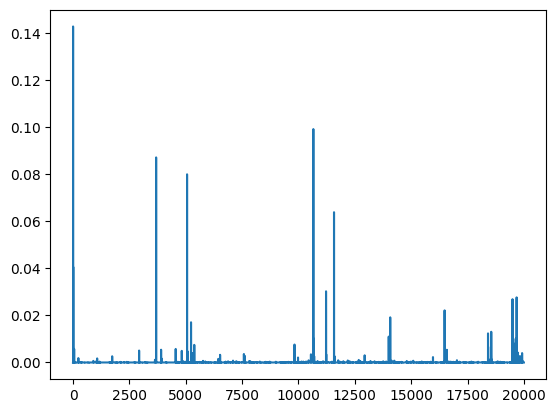

In [32]:
# Lets have a look at the probabilities
_ = plt.plot(F.softmax(data_pred/temp, -1).cpu().numpy().flatten())